In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
tissue_pos = pd.read_parquet("../spatial/tissue_positions.parquet")
tissue_pos.head(2)

,barcode,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres
0,s_008um_00000_00000-1,1,0,0,22368.311601,40591.942435
1,s_008um_00000_00001-1,1,0,1,22368.696123,40621.142051


In [3]:
tissue_pos.to_csv("../spatial/tissue_positions_list.csv", index=False)

In [4]:
p2 = sc.read_visium("../")
p2.var_names_make_unique() # making gene names unique
p2

/grid/westcott/home/nbhandar/miniconda3/envs/scpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/grid/westcott/home/nbhandar/miniconda3/envs/scpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/grid/westcott/home/nbhandar/miniconda3/envs/scpy/lib/python3.11/site-packages/scanpy/readwrite.py:494: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  positions = pd.read_csv(


AnnData object with n_obs × n_vars = 545913 × 18085
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
! rm "../spatial/tissue_positions_list.csv"

In [6]:
p2.layers['counts'] = p2.X.copy() # saving the raw counts
p2

AnnData object with n_obs × n_vars = 545913 × 18085
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
    layers: 'counts'

In [7]:
# normalize and log transform counts
sc.pp.normalize_total(p2)
sc.pp.log1p(p2)

/grid/westcott/home/nbhandar/miniconda3/envs/scpy/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [8]:
sc.pp.highly_variable_genes(p2, n_top_genes=2000, inplace=True, flavor='cell_ranger')
# or np.var()

In [8]:
p2.var

,gene_ids,feature_types,genome,highly_variable,means,dispersions,dispersions_norm
SAMD11,ENSG00000187634,Gene Expression,GRCh38,False,0.001529,1.032388,0.980875
NOC2L,ENSG00000188976,Gene Expression,GRCh38,False,0.004941,0.690696,-0.192463
KLHL17,ENSG00000187961,Gene Expression,GRCh38,False,0.001400,0.721245,-0.496134
PLEKHN1,ENSG00000187583,Gene Expression,GRCh38,False,0.002357,0.619376,-0.815359
PERM1,ENSG00000187642,Gene Expression,GRCh38,False,0.000060,0.993661,0.443878
...,...,...,...,...,...,...,...
MT-ND4L,ENSG00000212907,Gene Expression,GRCh38,False,0.403048,0.749670,0.831962
MT-ND4,ENSG00000198886,Gene Expression,GRCh38,False,1.213711,0.654503,-0.289254
MT-ND5,ENSG00000198786,Gene Expression,GRCh38,False,0.134569,0.771724,1.091788
MT-ND6,ENSG00000198695,Gene Expression,GRCh38,False,0.157982,0.745880,0.787311


In [9]:
p2.var['highly_variable'][p2.var['highly_variable']]

HES4       True
ISG15      True
MXRA8      True
VWA1       True
MMP23B     True
           ... 
TGIF2LY    True
DDX3Y      True
UTY        True
KDM5D      True
EIF1AY     True
Name: highly_variable, Length: 2000, dtype: bool

In [10]:
hvg_mask = p2.var['highly_variable']

In [11]:
gene_exp = p2[:, hvg_mask].X.T.toarray()

In [15]:
gene_exp

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
# pearson correlation
pearson_p2 = np.corrcoef(gene_exp)

In [17]:
gene_names = p2.var_names[hvg_mask]
gene_names
len(gene_names)

2000

In [18]:
pearson_p2df = pd.DataFrame(pearson_p2, index=gene_names, columns=gene_names)
pearson_p2df.head(2)

,HES4,ISG15,MXRA8,VWA1,MMP23B,SKI,MEGF6,CCDC27,VAMP3,PER3,...,BGN,PNCK,L1CAM,FLNA,CLIC2,TGIF2LY,DDX3Y,UTY,KDM5D,EIF1AY
HES4,1.000000,0.019486,0.013105,0.003068,0.001157,0.012722,0.002946,0.000474,0.002347,0.001626,...,0.022289,0.001077,-0.000101,0.016579,0.002718,-0.000091,0.007552,0.005055,0.007702,0.005491
ISG15,0.019486,1.000000,0.017287,0.007322,0.004803,0.013149,0.008263,-0.000554,0.006914,0.000244,...,0.031645,-0.001399,0.001697,0.015893,0.008416,-0.000191,0.006824,0.002794,0.006367,0.005580


In [19]:
pearson_p2df['SPINK4']

HES4      -0.004974
ISG15     -0.017895
MXRA8     -0.018464
VWA1      -0.005550
MMP23B    -0.005230
             ...   
TGIF2LY   -0.000215
DDX3Y      0.005763
UTY        0.021073
KDM5D      0.013639
EIF1AY     0.030476
Name: SPINK4, Length: 2000, dtype: float64

In [20]:
# get top 30 correlated genes
# exclude self

pos_corr_genes = pearson_p2df.apply(lambda x: x.nlargest(31).iloc[1:].index.tolist(), axis = 1)
neg_corr_genes = pearson_p2df.apply(lambda x:x.nsmallest(31).iloc[1: ].index.tolist(), axis =1)


In [21]:
pos_corr_genes

HES4       [VIM, COL4A1, SPARC, COL3A1, COL1A1, NOTCH3, I...
ISG15      [CXCL10, MX1, IFIT1, IFIT3, IFI6, OAS2, SPARC,...
MXRA8      [COL3A1, COL1A1, COL1A2, SPARC, LUM, MMP2, COL...
VWA1       [PLVAP, COL4A1, VWF, ENG, PECAM1, COL4A2, HSPG...
MMP23B     [COL3A1, COL1A1, COL1A2, SPARC, LUM, MMP2, THB...
                                 ...                        
TGIF2LY    [ITIH5, CORO1A, APOBR, EID1, FABP1, COL1A1, ZI...
DDX3Y      [VIM, CD74, COL3A1, SRGN, A2M, IGFBP7, SPARC, ...
UTY        [PIGR, IGKC, FCGBP, MUC2, CD74, VIM, JCHAIN, O...
KDM5D      [IGKC, JCHAIN, VIM, IGHG1, COL3A1, CD74, IGHA1...
EIF1AY     [PIGR, IGKC, OLFM4, VIM, JCHAIN, FCGBP, SOST, ...
Length: 2000, dtype: object

In [22]:
corr_df = pd.DataFrame({
    'Top_positvely_correlated' : pos_corr_genes,
    'Top_negatively_correlated' : neg_corr_genes
})

In [23]:
corr_df.to_csv('p2crc_hvgs_correlated_genes.csv')

In [24]:
corr_df

,Top_positvely_correlated,Top_negatively_correlated
HES4,"[VIM, COL4A1, SPARC, COL3A1, COL1A1, NOTCH3, I...","[LCN2, PIGR, FCGBP, AGR2, PI3, CLCA1, TSPAN1, ..."
ISG15,"[CXCL10, MX1, IFIT1, IFIT3, IFI6, OAS2, SPARC,...","[OLFM4, CLCA1, AGR2, SPINK4, DES, MUC2, FCGBP,..."
MXRA8,"[COL3A1, COL1A1, COL1A2, SPARC, LUM, MMP2, COL...","[FABP1, PIGR, PI3, FCGBP, AGR2, CKB, TSPAN1, M..."
VWA1,"[PLVAP, COL4A1, VWF, ENG, PECAM1, COL4A2, HSPG...","[SFRP4, IGKC, THBS2, JCHAIN, SFRP2, GREM1, ELN..."
MMP23B,"[COL3A1, COL1A1, COL1A2, SPARC, LUM, MMP2, THB...","[FABP1, PI3, PIGR, FCGBP, AGR2, TSPAN1, CKB, O..."
...,...,...
TGIF2LY,"[ITIH5, CORO1A, APOBR, EID1, FABP1, COL1A1, ZI...","[IGKC, COL3A1, TPM1, CD74, SPARC, TAGLN, COL1A..."
DDX3Y,"[VIM, CD74, COL3A1, SRGN, A2M, IGFBP7, SPARC, ...","[LCN2, CKB, PI3, CEACAM7, PCP4, MS4A12, SORBS2..."
UTY,"[PIGR, IGKC, FCGBP, MUC2, CD74, VIM, JCHAIN, O...","[SORBS2, CKB, RAB23, PCP4, NFIX, VEGFB, PRNP, ..."
KDM5D,"[IGKC, JCHAIN, VIM, IGHG1, COL3A1, CD74, IGHA1...","[PI3, LCN2, CKB, CXCL8, PLAUR, SOD2, G0S2, SOR..."


In [25]:
print(corr_df.loc['ISG15', 'Top_positvely_correlated'])
print(corr_df.loc['ISG15', 'Top_negatively_correlated'])

['CXCL10', 'MX1', 'IFIT1', 'IFIT3', 'IFI6', 'OAS2', 'SPARC', 'COL1A1', 'IFI44L', 'COL3A1', 'IFIT2', 'COL1A2', 'VIM', 'BST2', 'IFI44', 'LGALS1', 'IGFBP7', 'IGFBP3', 'COL4A1', 'MMP2', 'COL5A1', 'EPSTI1', 'LUM', 'TRIM22', 'GBP1', 'AEBP1', 'TIMP2', 'TIMP3', 'TIMP1', 'COL5A2']
['OLFM4', 'CLCA1', 'AGR2', 'SPINK4', 'DES', 'MUC2', 'FCGBP', 'PLA2G2A', 'FABP1', 'TFF3', 'ITLN1', 'MYH11', 'LCN2', 'PCP4', 'REG4', 'DMBT1', 'CA2', 'SORBS2', 'IGKC', 'SYNPO2', 'REG1A', 'PRUNE2', 'JCHAIN', 'MT1X', 'CA1', 'CKB', 'SYNM', 'MT1F', 'IGHM', 'HBA2']


In [26]:
print(corr_df.loc['FCGBP', 'Top_positvely_correlated'])
print(corr_df.loc['FCGBP', 'Top_negatively_correlated'])
# subsetting matrix 
top_FCGBP_pos = corr_df.loc['FCGBP', 'Top_positvely_correlated']
top_FCGBP_neg = corr_df.loc['FCGBP', 'Top_negatively_correlated']
genes_of_interest = ['FCGBP'] + top_FCGBP_pos + ['FCGBP'] + top_FCGBP_neg

['PIGR', 'MUC2', 'CLCA1', 'SPINK4', 'AGR2', 'TFF3', 'TSPAN1', 'OLFM4', 'ZG16', 'CA2', 'REG4', 'KRT20', 'ITLN1', 'LCN2', 'SLC26A3', 'PLA2G2A', 'DUOX2', 'SELENOP', 'CEACAM7', 'PARM1', 'CA4', 'GUCA2A', 'PADI2', 'MT2A', 'KLF4', 'CA1', 'DMBT1', 'MS4A12', 'CLCA4', 'PI3']
['COL1A1', 'VIM', 'SPARC', 'COL1A2', 'TAGLN', 'LGALS1', 'CALD1', 'IGFBP7', 'TIMP3', 'MMP2', 'FN1', 'MYL9', 'LUM', 'TIMP1', 'COL5A1', 'COL6A3', 'COL6A2', 'TPM2', 'COL4A1', 'MGP', 'DCN', 'FLNA', 'AEBP1', 'THBS1', 'ACTA2', 'ACTN1', 'C1S', 'C1R', 'VCAN', 'TIMP2']


In [27]:
print(corr_df.loc['ISG15', 'Top_positvely_correlated'])
print(corr_df.loc['ISG15', 'Top_negatively_correlated'])
# subsetting matrix 
#top_isg_pos = corr_df.loc['ISG15', 'Top_positvely_correlated']
#top_isg_neg = corr_df.loc['ISG15', 'Top_negatively_correlated']
#genes_of_interest = ['ISG15'] + top_isg_pos + top_isg_neg


['CXCL10', 'MX1', 'IFIT1', 'IFIT3', 'IFI6', 'OAS2', 'SPARC', 'COL1A1', 'IFI44L', 'COL3A1', 'IFIT2', 'COL1A2', 'VIM', 'BST2', 'IFI44', 'LGALS1', 'IGFBP7', 'IGFBP3', 'COL4A1', 'MMP2', 'COL5A1', 'EPSTI1', 'LUM', 'TRIM22', 'GBP1', 'AEBP1', 'TIMP2', 'TIMP3', 'TIMP1', 'COL5A2']
['OLFM4', 'CLCA1', 'AGR2', 'SPINK4', 'DES', 'MUC2', 'FCGBP', 'PLA2G2A', 'FABP1', 'TFF3', 'ITLN1', 'MYH11', 'LCN2', 'PCP4', 'REG4', 'DMBT1', 'CA2', 'SORBS2', 'IGKC', 'SYNPO2', 'REG1A', 'PRUNE2', 'JCHAIN', 'MT1X', 'CA1', 'CKB', 'SYNM', 'MT1F', 'IGHM', 'HBA2']


In [28]:
genes_of_interest = ['FCGBP'] + top_FCGBP_pos + ['FCGBP'] + top_FCGBP_neg
goi_df = pearson_p2df.loc[genes_of_interest, genes_of_interest]

In [29]:
goi_df

,FCGBP,PIGR,MUC2,CLCA1,SPINK4,AGR2,TFF3,TSPAN1,OLFM4,ZG16,...,DCN,FLNA,AEBP1,THBS1,ACTA2,ACTN1,C1S,C1R,VCAN,TIMP2
FCGBP,1.000000,0.721347,0.673341,0.544308,0.445889,0.429207,0.419248,0.416811,0.408416,0.400528,...,-0.055741,-0.055423,-0.055415,-0.054463,-0.053064,-0.053031,-0.052969,-0.052790,-0.052773,-0.052028
PIGR,0.721347,1.000000,0.577548,0.542890,0.446672,0.475652,0.407380,0.444589,0.511014,0.356035,...,-0.068598,-0.067171,-0.068903,-0.066880,-0.065354,-0.064815,-0.064961,-0.063057,-0.065631,-0.064887
MUC2,0.673341,0.577548,1.000000,0.500771,0.448756,0.396679,0.389807,0.320355,0.363235,0.354093,...,-0.045559,-0.045053,-0.045312,-0.044773,-0.043579,-0.042379,-0.043320,-0.042867,-0.043337,-0.042548
CLCA1,0.544308,0.542890,0.500771,1.000000,0.448936,0.349242,0.345355,0.164174,0.452457,0.164339,...,-0.040949,-0.039345,-0.041203,-0.043127,-0.038467,-0.033070,-0.040026,-0.039593,-0.039850,-0.040820
SPINK4,0.445889,0.446672,0.448756,0.448936,1.000000,0.349629,0.300293,0.132047,0.472027,0.138917,...,-0.035071,-0.035478,-0.035322,-0.038952,-0.033366,-0.027762,-0.033128,-0.032760,-0.035166,-0.035599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACTN1,-0.053031,-0.064815,-0.042379,-0.033070,-0.027762,-0.036191,-0.029478,-0.043549,-0.025407,-0.034169,...,0.035278,0.095599,0.059361,0.072286,0.112852,1.000000,0.060787,0.052605,0.045988,0.064491
C1S,-0.052969,-0.064961,-0.043320,-0.040026,-0.033128,-0.050991,-0.031500,-0.049221,-0.037947,-0.028678,...,0.213094,0.096995,0.205750,0.110007,0.119452,0.060787,1.000000,0.198123,0.178260,0.167397
C1R,-0.052790,-0.063057,-0.042867,-0.039593,-0.032760,-0.049030,-0.032135,-0.047042,-0.037250,-0.027243,...,0.200467,0.086249,0.191664,0.104813,0.111283,0.052605,0.198123,1.000000,0.165859,0.148814
VCAN,-0.052773,-0.065631,-0.043337,-0.039850,-0.035166,-0.049565,-0.032942,-0.046624,-0.041521,-0.026331,...,0.209772,0.054633,0.225846,0.136887,0.110862,0.045988,0.178260,0.165859,1.000000,0.171400


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
mask = np.triu(np.ones_like(goi_df, dtype=bool), 1)
#mask

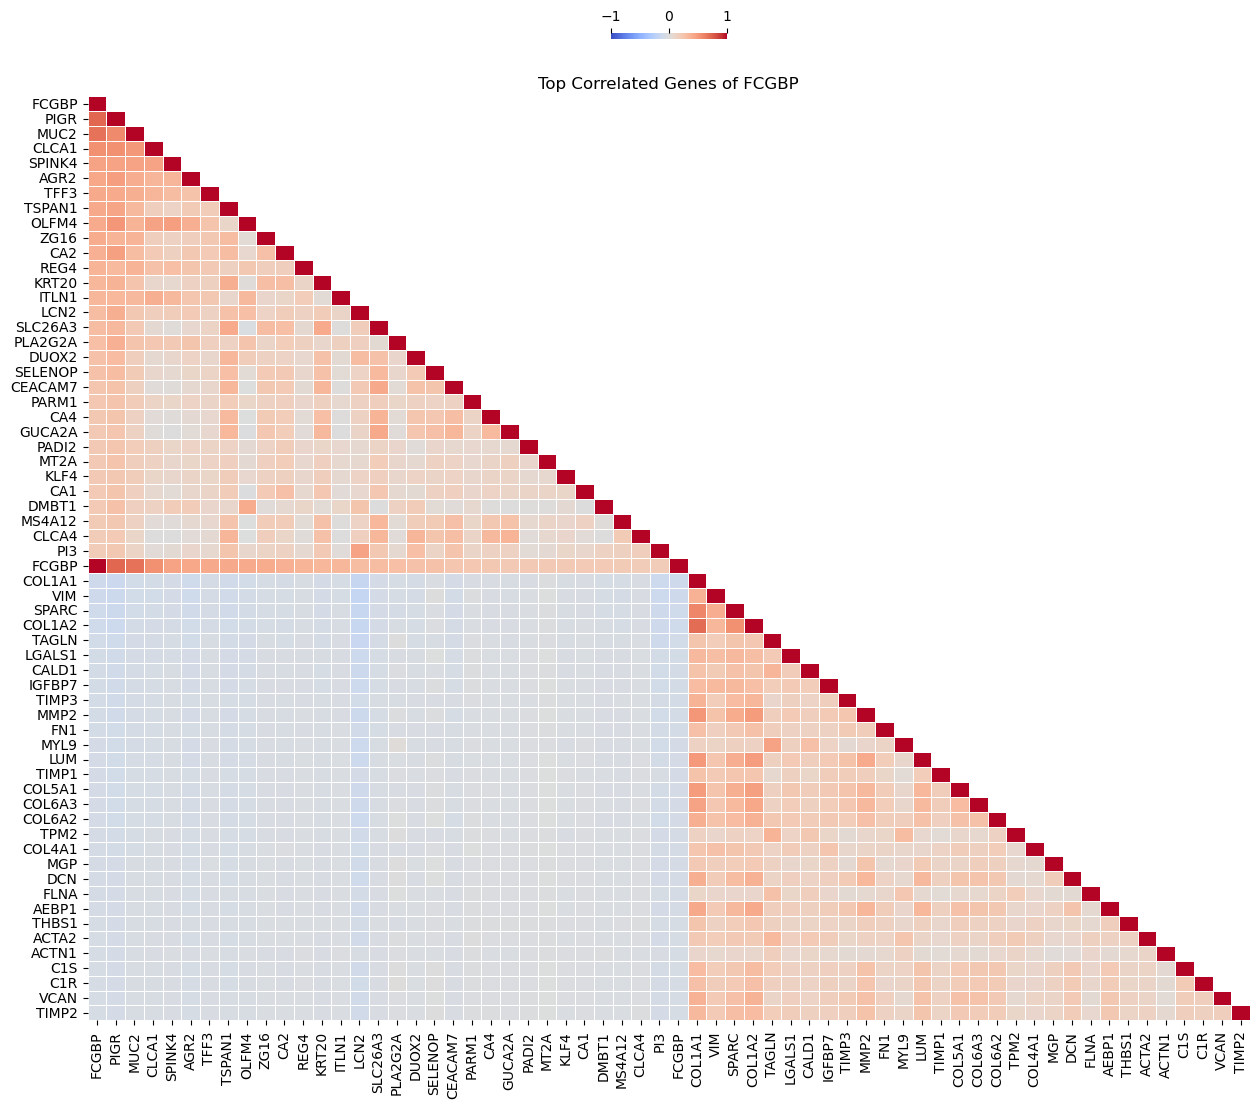

In [33]:

plt.figure(figsize=(15,15))
ax = sns.heatmap(goi_df, cmap='coolwarm', mask = mask, vmax=1, vmin=-1, 
                linewidths=0.5, linecolor='white',
                cbar_kws={'orientation': 'horizontal', 'shrink': 0.1,
                           'aspect': 20, "location": "top"})
plt.xticks(fontsize = 10)
plt.yticks(fontsize=10)
plt.title('Top Correlated Genes of FCGBP')
plt.savefig("./Figures/Correlated_genes_for_FCGBP.png", format="png")
plt.show()

In [34]:
np.fill_diagonal(pearson_p2df.values, 0)
pearson_p2df.head()

,HES4,ISG15,MXRA8,VWA1,MMP23B,SKI,MEGF6,CCDC27,VAMP3,PER3,...,BGN,PNCK,L1CAM,FLNA,CLIC2,TGIF2LY,DDX3Y,UTY,KDM5D,EIF1AY
HES4,0.000000,0.019486,0.013105,0.003068,0.001157,0.012722,0.002946,0.000474,0.002347,0.001626,...,0.022289,0.001077,-0.000101,0.016579,0.002718,-0.000091,0.007552,0.005055,0.007702,0.005491
ISG15,0.019486,0.000000,0.017287,0.007322,0.004803,0.013149,0.008263,-0.000554,0.006914,0.000244,...,0.031645,-0.001399,0.001697,0.015893,0.008416,-0.000191,0.006824,0.002794,0.006367,0.005580
MXRA8,0.013105,0.017287,0.000000,-0.003470,0.012946,0.022577,0.022723,-0.000854,0.003346,0.004940,...,0.090569,-0.000813,0.006763,0.038685,0.005460,-0.000183,0.006295,0.003353,0.008673,0.006078
VWA1,0.003068,0.007322,-0.003470,0.000000,-0.001768,0.011623,-0.004324,0.000101,0.006593,0.002171,...,-0.002030,0.007515,0.017250,0.025046,0.009043,-0.000190,0.009320,0.003673,0.003429,0.004491
MMP23B,0.001157,0.004803,0.012946,-0.001768,0.000000,0.004229,0.007306,-0.000248,0.004785,0.002096,...,0.020235,-0.001178,-0.001502,0.009150,0.000911,-0.000053,0.002410,0.000203,0.003234,0.001565


In [35]:
pearson_p2df.stack().nlargest(30)

COL3A1  COL1A1    0.724304
COL1A1  COL3A1    0.724304
PIGR    FCGBP     0.721347
FCGBP   PIGR      0.721347
COL1A1  COL1A2    0.699302
COL1A2  COL1A1    0.699302
COL3A1  COL1A2    0.682914
COL1A2  COL3A1    0.682914
MUC2    FCGBP     0.673341
FCGBP   MUC2      0.673341
SPARC   COL1A1    0.589913
COL1A1  SPARC     0.589913
CHGA    CHGB      0.586961
CHGB    CHGA      0.586961
PIGR    MUC2      0.577548
MUC2    PIGR      0.577548
SPARC   COL3A1    0.576739
COL3A1  SPARC     0.576739
IGKC    IGHG1     0.570329
IGHG1   IGKC      0.570329
DES     MYH11     0.567870
MYH11   DES       0.567870
CLCA1   FCGBP     0.544308
FCGBP   CLCA1     0.544308
CLCA1   PIGR      0.542890
PIGR    CLCA1     0.542890
SPARC   COL1A2    0.542157
COL1A2  SPARC     0.542157
IGKC    JCHAIN    0.537305
JCHAIN  IGKC      0.537305
dtype: float64

In [36]:
pearson_p2df.stack().nsmallest(30)

FABP1   COL3A1   -0.182110
COL3A1  FABP1    -0.182110
        LCN2     -0.181565
LCN2    COL3A1   -0.181565
FABP1   VIM      -0.179908
VIM     FABP1    -0.179908
        LCN2     -0.170736
LCN2    VIM      -0.170736
FABP1   COL1A1   -0.163134
COL1A1  FABP1    -0.163134
LCN2    COL1A1   -0.162299
COL1A1  LCN2     -0.162299
SPARC   LCN2     -0.154267
LCN2    SPARC    -0.154267
FABP1   SPARC    -0.153590
SPARC   FABP1    -0.153590
FABP1   COL1A2   -0.149807
COL1A2  FABP1    -0.149807
FABP1   TAGLN    -0.149709
TAGLN   FABP1    -0.149709
COL1A2  LCN2     -0.149027
LCN2    COL1A2   -0.149027
        TAGLN    -0.147272
TAGLN   LCN2     -0.147272
PIGR    COL3A1   -0.136872
COL3A1  PIGR     -0.136872
FABP1   IGKC     -0.135083
IGKC    FABP1    -0.135083
PIGR    COL1A1   -0.128559
COL1A1  PIGR     -0.128559
dtype: float64

In [37]:
heatmap_data = pd.DataFrame({
    'Gene': top_FCGBP_pos, 
    'Correlation': pearson_p2df.loc['FCGBP', top_FCGBP_pos],
    'Type': ['Positively Correlated'] * len(top_FCGBP_pos)
})



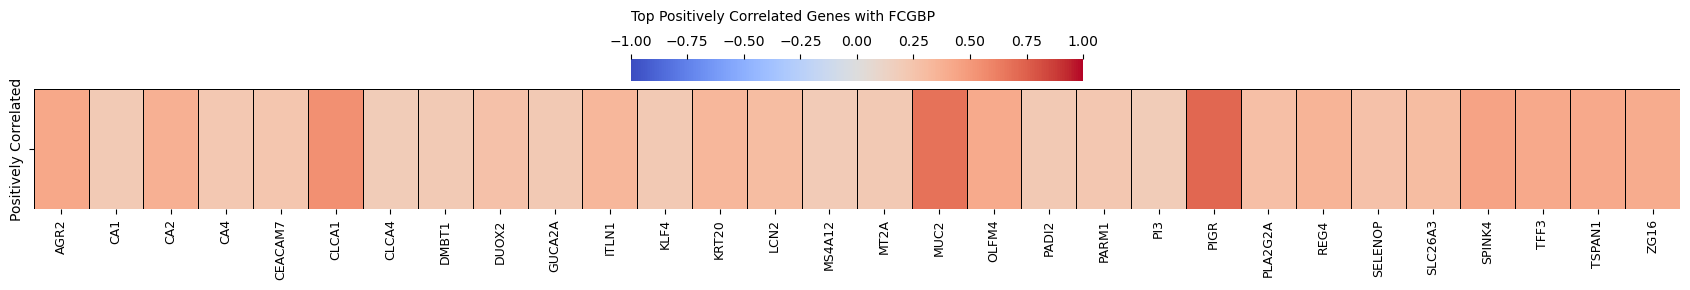

In [39]:
pivot_df = heatmap_data.pivot(index='Type', columns='Gene', values='Correlation')
plt.figure(figsize=(17, 3))
ax = sns.heatmap(
    pivot_df,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    cbar_kws={
        'orientation': 'horizontal',
        'shrink': 0.6,
        'aspect': 20,
        'location': 'top'
    },
    linewidths=0.5,
    linecolor='black'
)

ax.set_ylabel('')
ax.set_xlabel('')
cbar = ax.collections[0].colorbar
cbar.set_label('Top Positively Correlated Genes with FCGBP', labelpad=10, loc='left')
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=10)
plt.title('')
plt.tight_layout()
plt.savefig("./Figures/Pos_Correlated_genes_for_FCGBP.png", format="png")
plt.show()

In [40]:
heatmap_data = pd.DataFrame({
    'Gene': top_FCGBP_neg, 
    'Correlation': pearson_p2df.loc['FCGBP', top_FCGBP_neg],
    'Type': ['Negatively Correlated'] * len(top_FCGBP_neg)
})
(heatmap_data.head())
pivot_df = heatmap_data.pivot(index='Type', columns='Gene', values='Correlation')

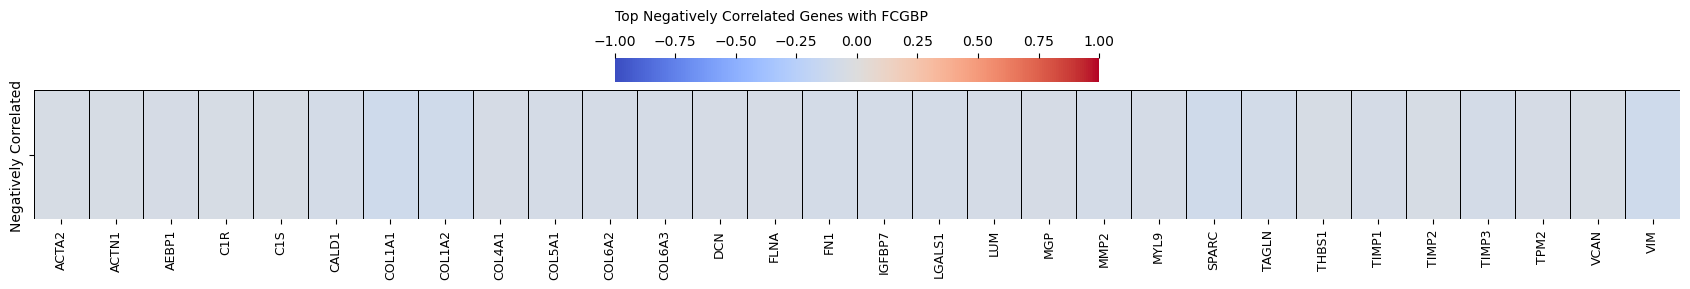

In [41]:
plt.figure(figsize=(17, 3))
ax = sns.heatmap(
    pivot_df,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    cbar_kws={
        'orientation': 'horizontal',
        'shrink': 0.6,
        'aspect': 20,
        'location': 'top'
    },
    linewidths=0.5,
    linecolor='black'
)

ax.set_ylabel('')
ax.set_xlabel('')
cbar = ax.collections[0].colorbar
cbar.set_label('Top Negatively Correlated Genes with FCGBP', labelpad=10, loc='left')

plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=10)
plt.title('')
plt.tight_layout()
plt.savefig("./Figures/Neg_Correlated_genes_for_FCGBP.png", format="png")
plt.show()